In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [6]:
categorical_cols = ['lead_source', 'industry','employment_status', 'location']

In [7]:
# lead_source                  object
# industry                     object
# number_of_courses_viewed      int64
# annual_income               float64
# employment_status            object
# location                     object
# interaction_count             int64
# lead_score                  float64
# converted                     int64
numerical_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

### Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
  - For caterogiral features, replace them with 'NA'
  - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [8]:
# missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [9]:
# for caterogiral features, replace them with 'NA'
for c in categorical_cols:
    df[c] = df[c].fillna('NA')

In [10]:
# for numerical columns, replace with 0.0
for c in numerical_cols:
    df[c] = df[c].fillna(0.0)

In [11]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [12]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`/
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
len(df_train), len(df_val), len(df_test)

(876, 293, 293)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [13]:
# - For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
# - Use the training dataset for that

# If your AUC is < 0.5, invert this variable by putting "-" in front
for c in numerical_cols:
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(df_train['converted'], df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(df_train['converted'], -df_train[c])
    print(f'AUC for {c}: {auc}')

AUC for number_of_courses_viewed: 0.7635680590007088
AUC for annual_income: 0.5519578313253012
AUC for interaction_count: 0.738270176293409
AUC for lead_score: 0.6144993577250176



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [14]:
# apply one-hot encoding to categorical columns using DictVectorizer
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
train_dicts = df_train[categorical_cols + numerical_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train['converted'].values
model.fit(X_train, y_train)
val_dicts = df_val[categorical_cols + numerical_cols].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val['converted'].values
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'AUC on validation set: {auc}')


AUC on validation set: 0.8171316268814112


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

Precision: 0.6693877551020408
Recall: 0.9590643274853801


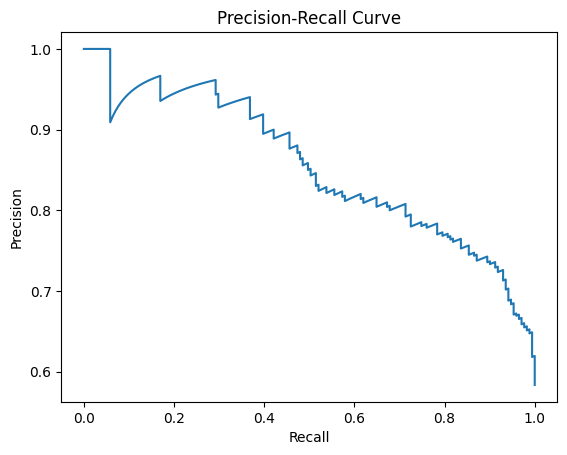

Best threshold: 0.5535908611718586


In [16]:
# compute precision and recall
from sklearn.metrics import precision_score, recall_score
y_pred_binary = (y_pred >= 0.5).astype(int)
precision = precision_score(y_val, y_pred_binary)   
recall = recall_score(y_val, y_pred_binary)
print(f'Precision: {precision}')
print(f'Recall: {recall}')  
# plot precision-recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
# at which threshold do precision and recall curves intersect?
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
print(f'Best threshold: {best_threshold}')

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [18]:
# compute f1 for all thresholds from 0.0 to 1.0 with step 0.01
# be careful of division by zero
f1_scores = []
thresholds_list = np.arange(0.0, 1.01, 0.01)
for t in thresholds_list:
    y_pred_binary = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds_list[best_f1_index]
print(f'Best F1 threshold: {best_f1_threshold}')
print(f'Best F1 score: {f1_scores[best_f1_index]}')


Best F1 threshold: 0.5700000000000001
Best F1 score: 0.8124999999999999


### Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [19]:
# use KFold from sklearn to split the data into 5 folds, random_state=1, shuffle=True
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for fold, (train_index, val_index) in enumerate(kf.split(df_full_train)):
    df_train_kf = df_full_train.iloc[train_index]
    df_val_kf = df_full_train.iloc[val_index]
    
    train_dicts = df_train_kf[categorical_cols + numerical_cols].to_dict(orient='records')
    X_train_kf = dv.fit_transform(train_dicts)
    y_train_kf = df_train_kf['converted'].values
    model.fit(X_train_kf, y_train_kf)
    
    val_dicts = df_val_kf[categorical_cols + numerical_cols].to_dict(orient='records')
    X_val_kf = dv.transform(val_dicts)
    y_val_kf = df_val_kf['converted'].values
    y_pred_kf = model.predict_proba(X_val_kf)[:, 1]
    auc = roc_auc_score(y_val_kf, y_pred_kf)
    print(f'Fold {fold + 1}, AUC: {auc}')

Fold 1, AUC: 0.8060745924216483
Fold 2, AUC: 0.8713738368910783
Fold 3, AUC: 0.7754320118852139
Fold 4, AUC: 0.8018368617683685
Fold 5, AUC: 0.8558272713202291


In [21]:
# what is the standard deviation of the AUC scores across the folds?

auc_scores = [] 
for fold, (train_index, val_index) in enumerate(kf.split(df_full_train)):
    df_train_kf = df_full_train.iloc[train_index]
    df_val_kf = df_full_train.iloc[val_index]
    
    train_dicts = df_train_kf[categorical_cols + numerical_cols].to_dict(orient='records')
    X_train_kf = dv.fit_transform(train_dicts)
    y_train_kf = df_train_kf['converted'].values
    model.fit(X_train_kf, y_train_kf)
    
    val_dicts = df_val_kf[categorical_cols + numerical_cols].to_dict(orient='records')
    X_val_kf = dv.transform(val_dicts)
    y_val_kf = df_val_kf['converted'].values
    y_pred_kf = model.predict_proba(X_val_kf)[:, 1]
    auc = roc_auc_score(y_val_kf, y_pred_kf)
    auc_scores.append(auc)
    print(f'Fold {fold + 1}, AUC: {auc}')
    # calculate standard deviation
std_auc = np.std(auc_scores)
print(f'Standard deviation of AUC scores across folds: {std_auc}')

Fold 1, AUC: 0.8060745924216483
Fold 2, AUC: 0.8713738368910783
Fold 3, AUC: 0.7754320118852139
Fold 4, AUC: 0.8018368617683685
Fold 5, AUC: 0.8558272713202291
Standard deviation of AUC scores across folds: 0.03580711942905165


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [22]:
# use 5-fold cross-validation to find the best value of C from the list [0.000001, 0.001, 1]
# KFold with same parameters as before
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1] 
best_C = None
best_auc = 0.0
for C in C_values:
    auc_scores = []
    for fold, (train_index, val_index) in enumerate(kf.split(df_full_train)):
        df_train_kf = df_full_train.iloc[train_index]
        df_val_kf = df_full_train.iloc[val_index]
        
        train_dicts = df_train_kf[categorical_cols + numerical_cols].to_dict(orient='records')
        X_train_kf = dv.fit_transform(train_dicts)
        y_train_kf = df_train_kf['converted'].values
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_kf, y_train_kf)
        
        val_dicts = df_val_kf[categorical_cols + numerical_cols].to_dict(orient='records')
        X_val_kf = dv.transform(val_dicts)
        y_val_kf = df_val_kf['converted'].values
        y_pred_kf = model.predict_proba(X_val_kf)[:, 1]
        auc = roc_auc_score(y_val_kf, y_pred_kf)
        auc_scores.append(auc)
    mean_auc = np.mean(auc_scores)
    print(f'C: {C}, Mean AUC: {mean_auc}')
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_C = C
print(f'Best C: {best_C}, Best Mean AUC: {best_auc}')   


C: 1e-06, Mean AUC: 0.560207852870275
C: 0.001, Mean AUC: 0.8668780317675395
C: 1, Mean AUC: 0.8221089148573075
Best C: 0.001, Best Mean AUC: 0.8668780317675395
